# Single-Cell Regulatory Network Analysis – SCENIC Pipeline  
**Author:** Miguel Castresana Aguirre  
**Date:** February 1, 2025  

## Importing Required Libraries


In [1]:
from pathlib import Path
import yaml
import scanpy as sc
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import time
from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2
import os, glob, re, json, zlib, base64, subprocess
import seaborn as sns
from pyscenic.rss import regulon_specificity_scores
from pyscenic.binarization import binarize

C:\Users\migcas\AppData\Local\anaconda3\envs\py_sc_analysis_env\lib\site-packages\loompy\bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
C:\Users\migcas\AppData\Local\anaconda3\envs\py_sc_analysis_env\lib\site-packages\loompy\bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_t

# SCENIC Preprocessing: Loading, Filtering, and Loom File Creation

This notebook performs **SCENIC preprocessing** on single-cell gene expression data.

## **Workflow:**
1. **Load Configuration:**
   - Reads paths from a YAML file.
   - Creates necessary directories.

2. **Read and Filter Data:**
   - Loads a **10x matrix** into an AnnData object.
   - Filters metadata and genes based on user-defined lists.

3. **Quality Control (QC):**
   - Computes gene expression metrics.
   - Filters cells based on mitochondrial content and gene count thresholds.
   - Visualizes QC distributions.

4. **Prepare SCENIC Input Files:**
   - Saves **unfiltered** and **filtered** expression matrices as **Loom** files.
   - Writes a filtered AnnData object for downstream SCENIC analysis.

5. **Process Each Group Separately:**
   - Iterates over groups (e.g., phases, subtypes) and applies filtering.
   - Saves processed data per group.

## **Output:**
- Filtered **AnnData (.h5ad)** and **Loom** files.
- Quality control metrics and plots.

This pipeline ensures **clean and well-structured** single-cell data for SCENIC-based **regulon inference**.


Configuration loaded successfully.


C:\Users\migcas\AppData\Local\anaconda3\envs\py_sc_analysis_env\lib\site-packages\session_info\main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


-----
anndata     0.10.9
scanpy      1.9.5
-----
PIL                         11.1.0
anyio                       NA
arboreto                    NA
arrow                       1.3.0
asttokens                   NA
attr                        25.1.0
attrs                       25.1.0
babel                       2.17.0
brotli                      1.1.0
certifi                     2025.01.31
cffi                        1.17.1
charset_normalizer          3.4.1
click                       8.1.8
cloudpickle                 3.1.1
colorama                    0.4.6
comm                        0.2.2
cycler                      0.12.1
cython_runtime              NA
cytoolz                     1.0.1
dask                        2023.5.0
dateutil                    2.9.0.post0
debugpy                     1.8.12
decorator                   5.2.1
defusedxml                  0.7.1
distributed                 2023.5.0
exceptiongroup              1.2.2
executing                   2.1.0
fastjsonschema       

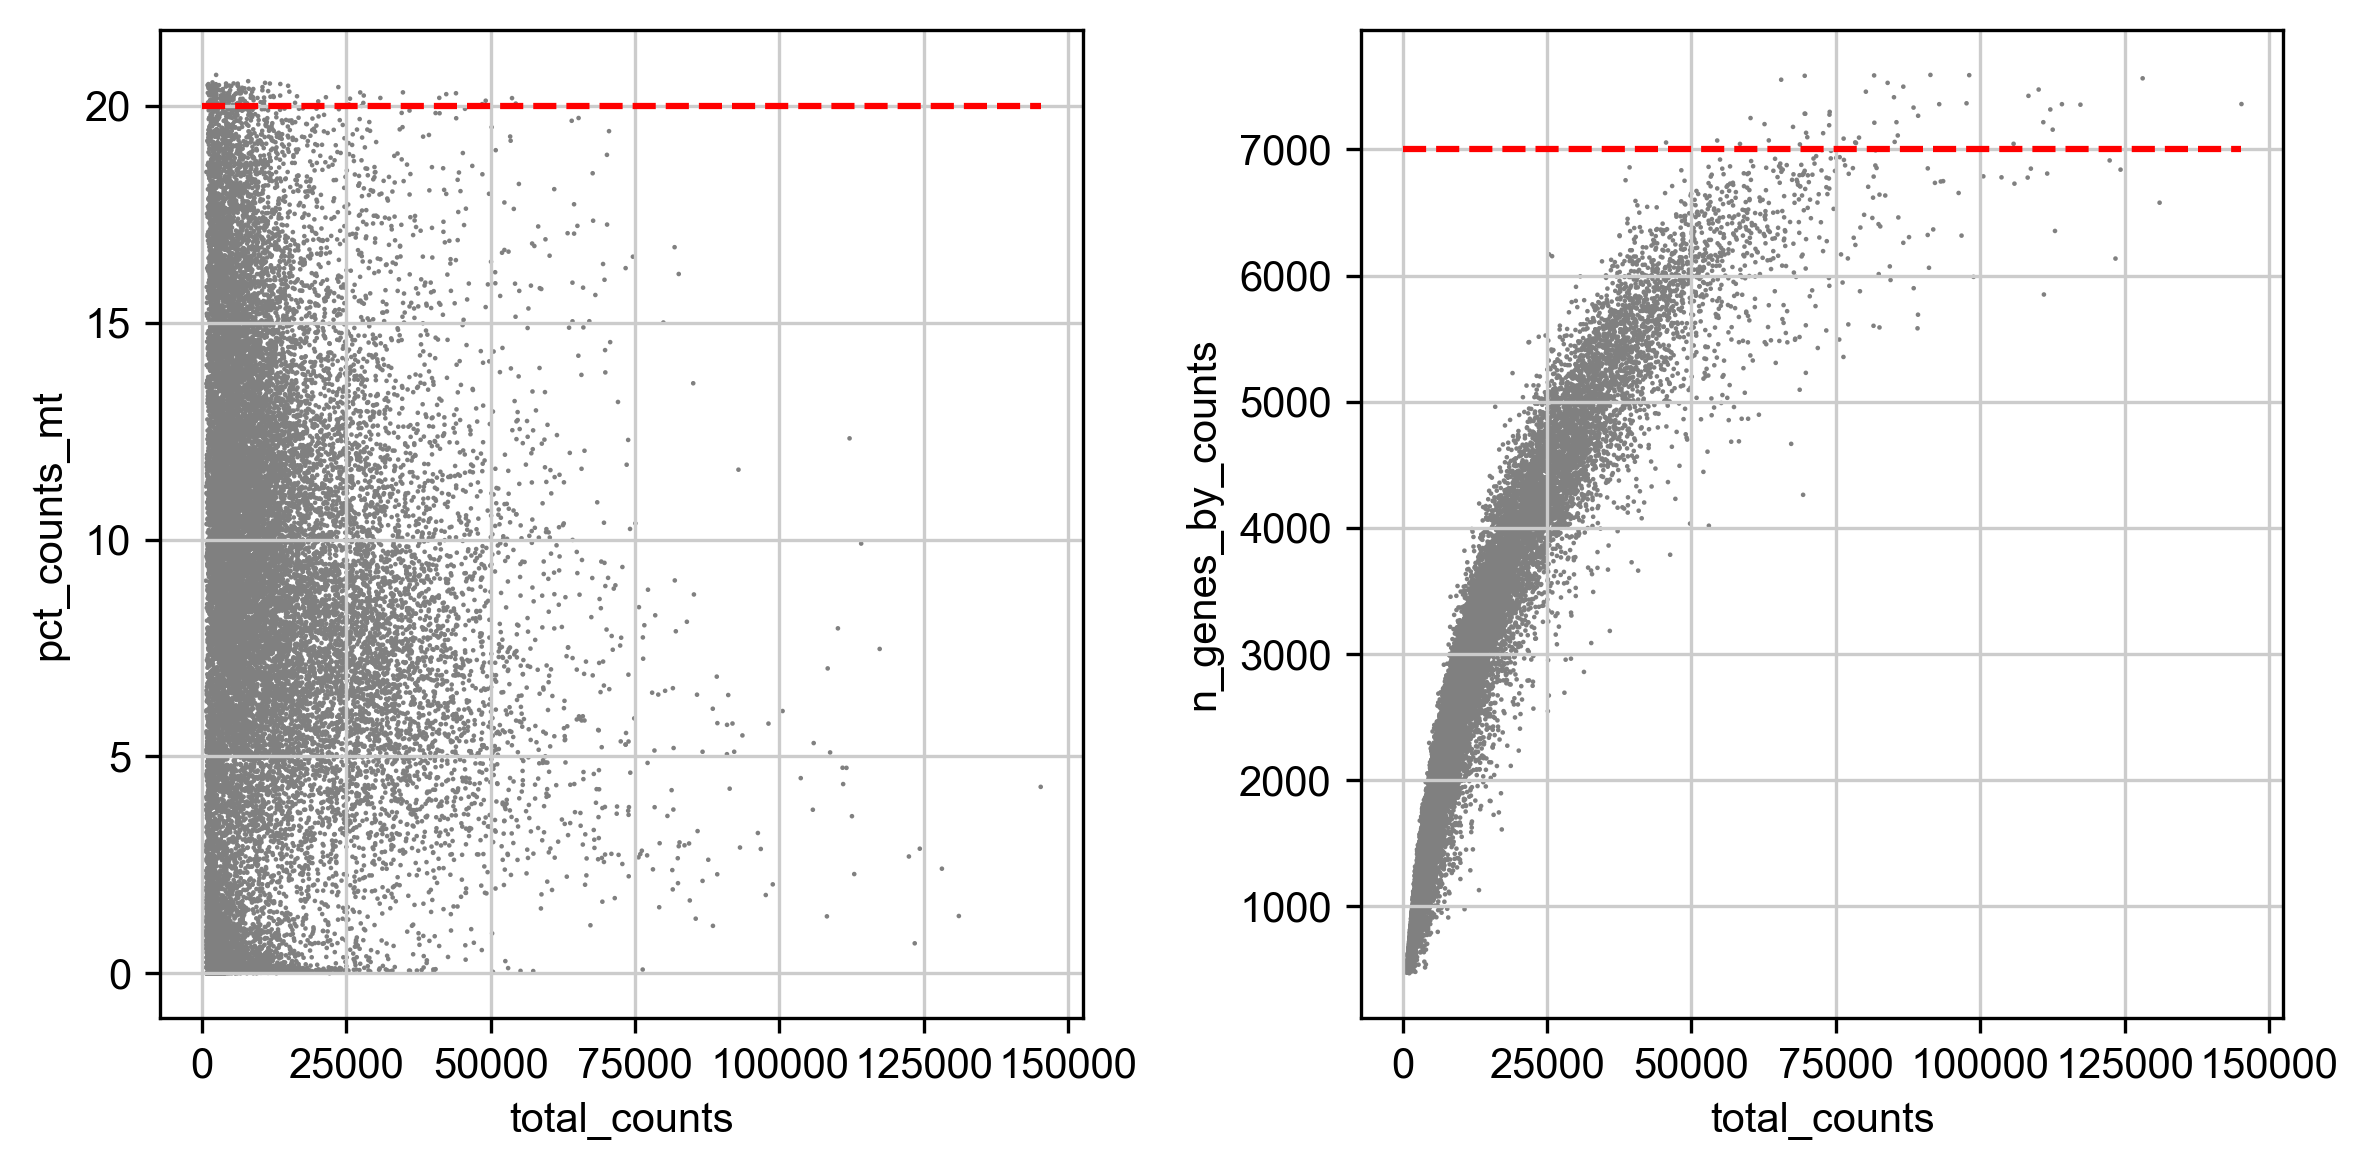

C:\Users\migcas\AppData\Local\anaconda3\envs\py_sc_analysis_env\lib\site-packages\session_info\main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


-----
anndata     0.10.9
scanpy      1.9.5
-----
PIL                         11.1.0
anyio                       NA
arboreto                    NA
arrow                       1.3.0
asttokens                   NA
attr                        25.1.0
attrs                       25.1.0
babel                       2.17.0
brotli                      1.1.0
certifi                     2025.01.31
cffi                        1.17.1
charset_normalizer          3.4.1
click                       8.1.8
cloudpickle                 3.1.1
colorama                    0.4.6
comm                        0.2.2
cycler                      0.12.1
cython_runtime              NA
cytoolz                     1.0.1
dask                        2023.5.0
dateutil                    2.9.0.post0
debugpy                     1.8.12
decorator                   5.2.1
defusedxml                  0.7.1
distributed                 2023.5.0
exceptiongroup              1.2.2
executing                   2.1.0
fastjsonschema       

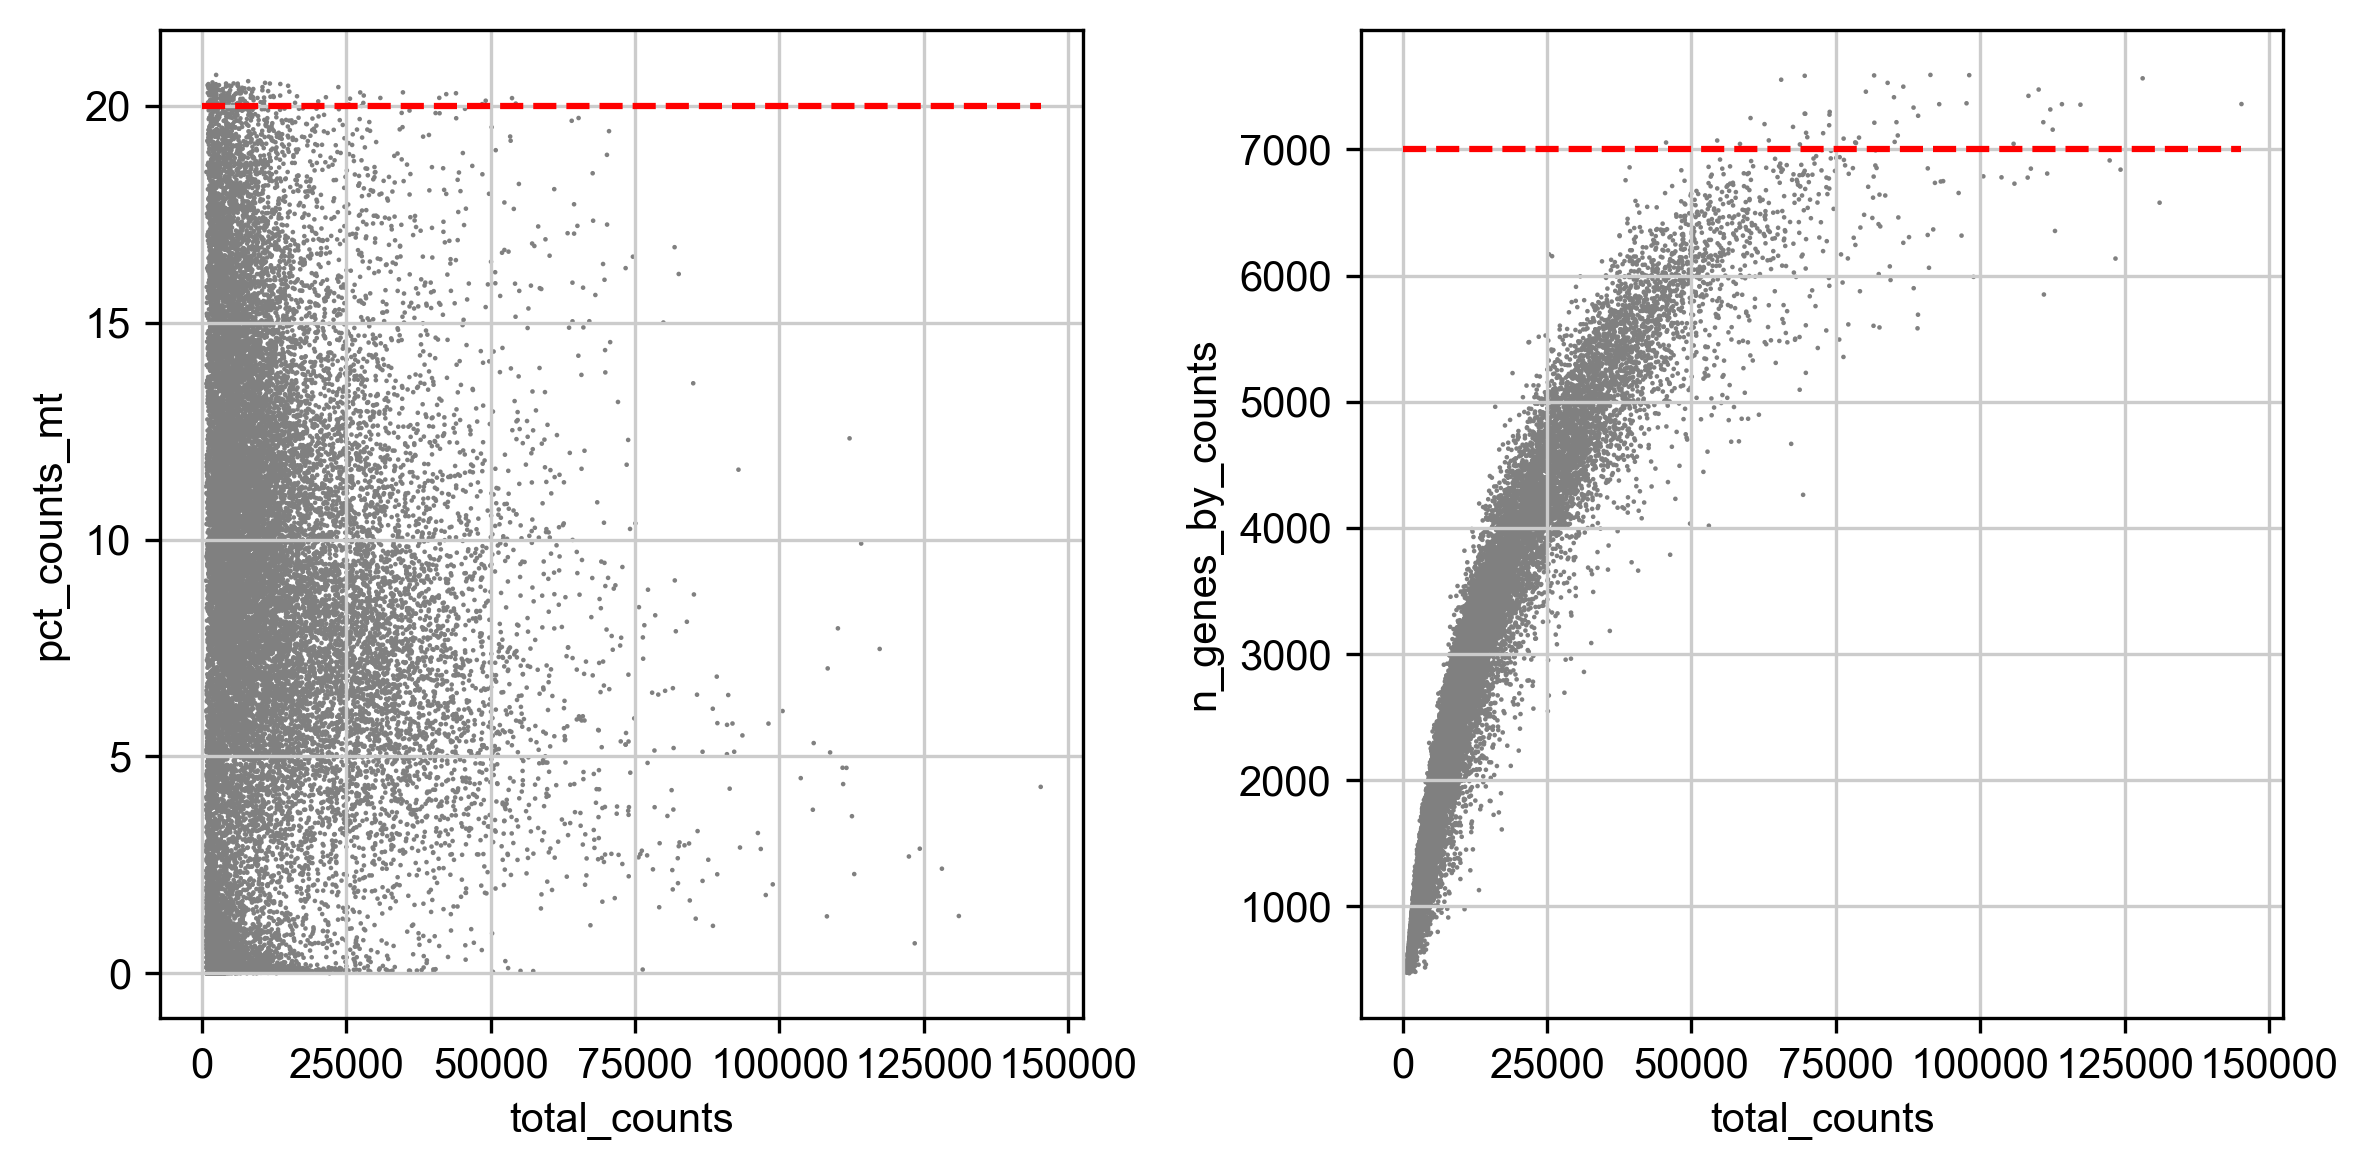

C:\Users\migcas\AppData\Local\anaconda3\envs\py_sc_analysis_env\lib\site-packages\session_info\main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


-----
anndata     0.10.9
scanpy      1.9.5
-----
PIL                         11.1.0
anyio                       NA
arboreto                    NA
arrow                       1.3.0
asttokens                   NA
attr                        25.1.0
attrs                       25.1.0
babel                       2.17.0
brotli                      1.1.0
certifi                     2025.01.31
cffi                        1.17.1
charset_normalizer          3.4.1
click                       8.1.8
cloudpickle                 3.1.1
colorama                    0.4.6
comm                        0.2.2
cycler                      0.12.1
cython_runtime              NA
cytoolz                     1.0.1
dask                        2023.5.0
dateutil                    2.9.0.post0
debugpy                     1.8.12
decorator                   5.2.1
defusedxml                  0.7.1
distributed                 2023.5.0
exceptiongroup              1.2.2
executing                   2.1.0
fastjsonschema       

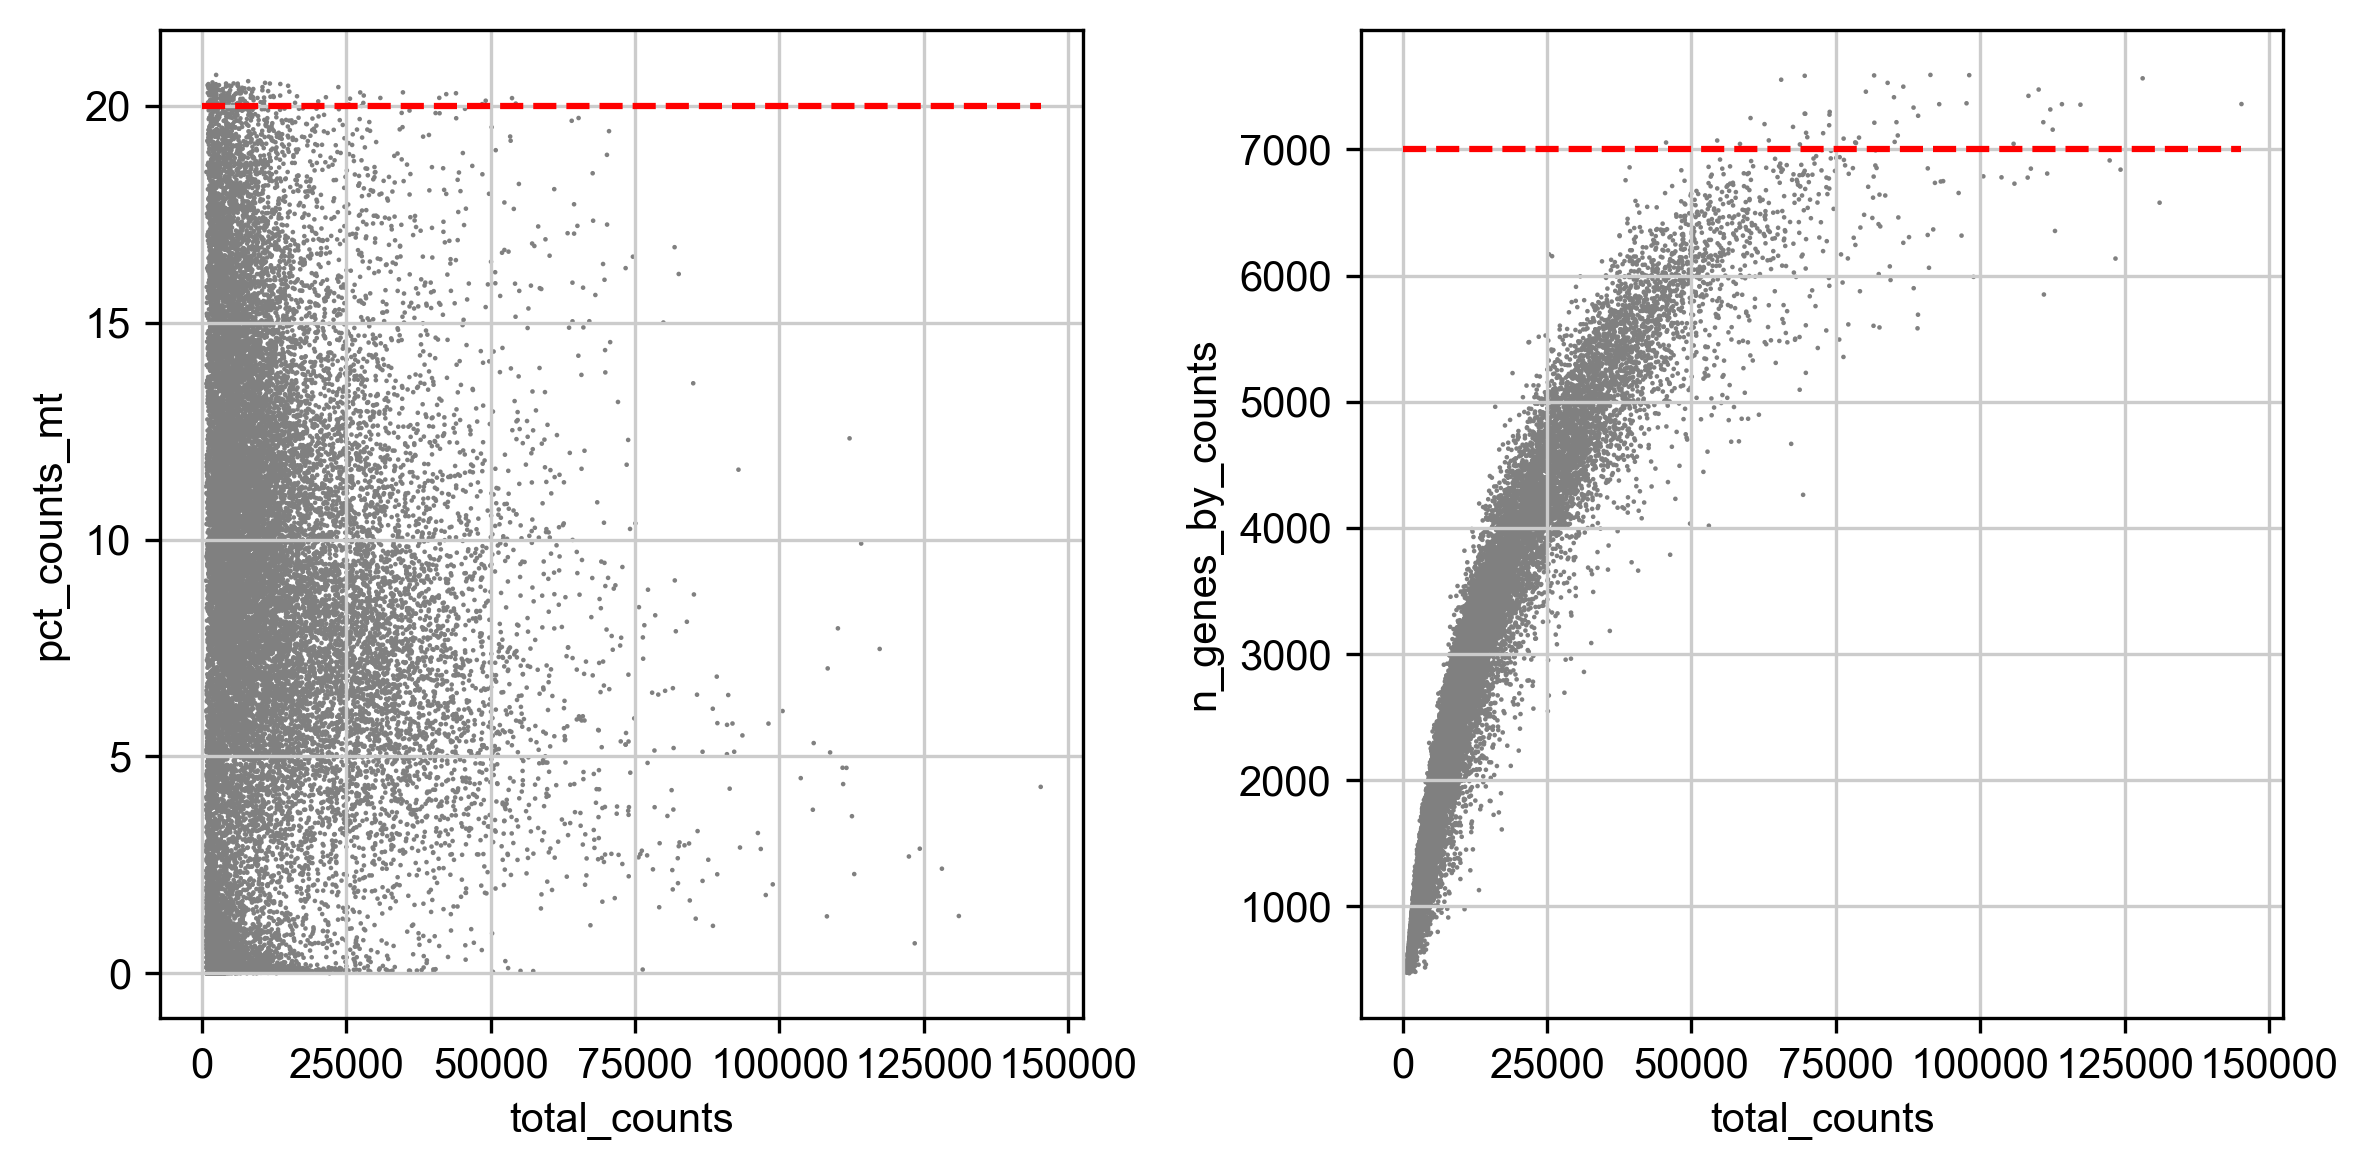

C:\Users\migcas\AppData\Local\anaconda3\envs\py_sc_analysis_env\lib\site-packages\session_info\main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


-----
anndata     0.10.9
scanpy      1.9.5
-----
PIL                         11.1.0
anyio                       NA
arboreto                    NA
arrow                       1.3.0
asttokens                   NA
attr                        25.1.0
attrs                       25.1.0
babel                       2.17.0
brotli                      1.1.0
certifi                     2025.01.31
cffi                        1.17.1
charset_normalizer          3.4.1
click                       8.1.8
cloudpickle                 3.1.1
colorama                    0.4.6
comm                        0.2.2
cycler                      0.12.1
cython_runtime              NA
cytoolz                     1.0.1
dask                        2023.5.0
dateutil                    2.9.0.post0
debugpy                     1.8.12
decorator                   5.2.1
defusedxml                  0.7.1
distributed                 2023.5.0
exceptiongroup              1.2.2
executing                   2.1.0
fastjsonschema       

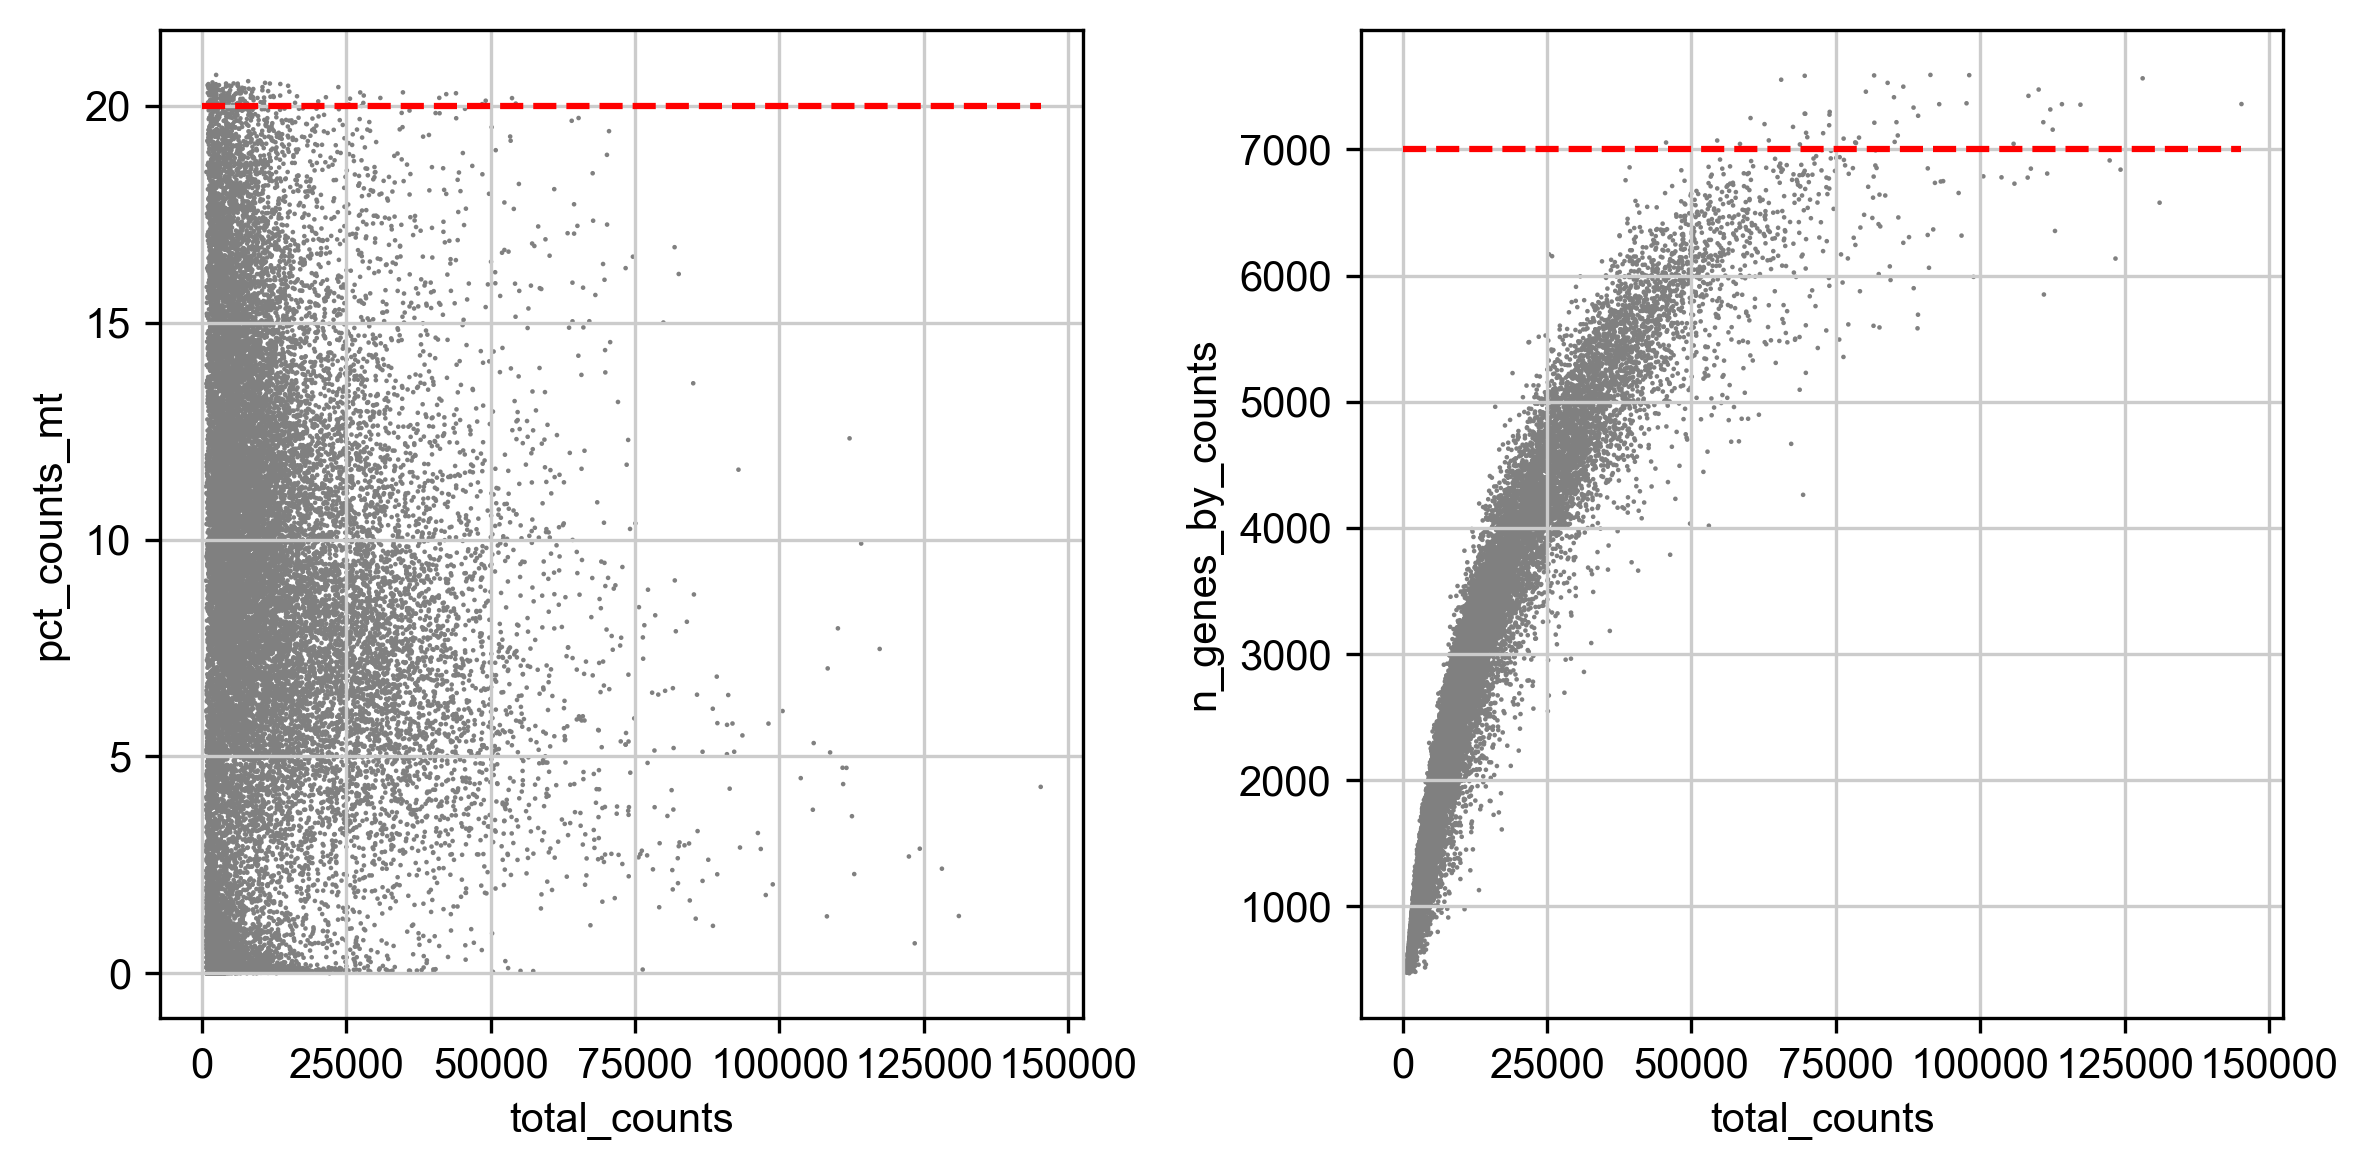

[None, None, None, None]

In [2]:

# ---------------------------
# Load configuration from YAML file
# ---------------------------
config_file = Path("C:/Users/migcas/OneDrive - Karolinska Institutet/Desktop/omega_single_cell/src/repository/repository_final/GRN/config_scenic.yaml")
with config_file.open("r") as f:
    config = yaml.safe_load(f)

# Extract paths from config
f_mtx_dir = Path(os.path.expanduser(config["f_mtx_dir"]))
base_project_dir = Path(config["base_project_dir"])
metadata_file = config["metadata_file"]
gene_list_file = config["gene_list_file"]

# Create base_project_dir if it doesn't exist
if not base_project_dir.exists():
    print(f"Base project directory {base_project_dir} does not exist. Creating it...")
    base_project_dir.mkdir(parents=True, exist_ok=True)

# Construct full paths for metadata and gene list files and check if they exist
metadata_path = base_project_dir / metadata_file
if not metadata_path.exists():
    raise FileNotFoundError(f"Metadata file not found: {metadata_path}")

gene_list_path = base_project_dir / gene_list_file
if not gene_list_path.exists():
    raise FileNotFoundError(f"Gene list file not found: {gene_list_path}")

print("Configuration loaded successfully.")

# Determine analysis mode and select appropriate lists and metadata filter column
analysis_mode = config["analysis_mode"]
if analysis_mode == "phase":
    file_list = config.get("phase_files")
    group_list = config.get("phase_groups")
    metadata_filter_column = "phase"  # Assumes metadata CSV has a column "phase"
elif analysis_mode == "subtype":
    file_list = config.get("subgroup_files")
    group_list = config.get("subtype_groups")
    metadata_filter_column = "subtype"  # Assumes metadata CSV has a column "subtype"
elif analysis_mode == "no_phase":
    # In "no_phase" mode, process all cells without filtering based on metadata.
    file_list = ["all"]    # A single group representing all cells
    group_list = [None]     # No specific group name is needed
    metadata_filter_column = None  # Skip metadata filtering
else:
    raise ValueError("Unknown analysis_mode: {}".format(analysis_mode))

# ---------------------------
# Read 10x Matrix and create a global AnnData copy
# ---------------------------
adata_all = sc.read_10x_mtx(str(f_mtx_dir), var_names="gene_symbols", cache=False).copy()

# ---------------------------
# Define a processing function for each group
# ---------------------------
def process_group(file_prefix, current_group):
    # Build working directory and switch to it
    current_dir = base_project_dir / file_prefix
    current_dir.mkdir(parents=True, exist_ok=True)
    os.chdir(current_dir)
    
    # Define filenames for outputs (as Paths)
    unfiltered_loom_path      = current_dir / "unfiltered.loom"
    filtered_scenic_loom_path = current_dir / "filtered_scenic.loom"
    anndata_path              = current_dir / "anndata.h5ad"
    
    # Set scanpy settings
    sc.settings.verbosity = 3
    sc.settings.njobs = 10
    sc.logging.print_versions()
    sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)
    
    # Start from a fresh copy of the global AnnData object
    adata = adata_all.copy()
    
    # --- FILTER METADATA AND GENES ---
    # Read metadata from CSV and set index to 'Cell'
    df_metadata = pd.read_csv(str(metadata_path), sep=",").set_index("Cell")
    
    # Subset AnnData to include only cells present in metadata
    adata = adata[adata.obs_names.isin(df_metadata.index)]
    
    # Read the gene list (assumes one gene per line after header) and subset AnnData
    with gene_list_path.open("r") as gf:
        next(gf)  # Skip header if needed
        gene_list = [line.strip() for line in gf if line.strip()]
    if not gene_list:
        raise ValueError(f"Gene list file {gene_list_path} is empty or improperly formatted.")
    adata = adata[:, adata.var_names.isin(gene_list)]
    
    print("Cells after metadata filter:", adata.obs_names.tolist())
    
    # Create row and column attributes for loom export
    row_attrs = {"Gene": np.array(adata.var.index)}
    col_attrs = {
        "CellID": np.array(adata.obs.index),
        "nGene": np.array((adata.X.transpose() > 0).sum(axis=0)).flatten(),
        "nUMI":  np.array(adata.X.transpose().sum(axis=0)).flatten(),
    }
    
    # Write loom file with unfiltered data
    lp.create(str(unfiltered_loom_path), adata.X.transpose(), row_attrs, col_attrs)
    
    # --- INITIAL/BASIC FILTERING ---
    # Re-read from the loom file
    adata = sc.read_loom(str(unfiltered_loom_path))
    print("Initial shape:", adata.shape)
    
    # Calculate basic gene-level metrics
    nCountsPerGene = np.sum(adata.X, axis=0)
    nCellsPerGene  = np.sum(adata.X > 0, axis=0)
    print("Counts per gene range:", nCountsPerGene.min(), "-", nCountsPerGene.max())
    print("Cells per gene range:", nCellsPerGene.min(), "-", nCellsPerGene.max())
    
    nCells = adata.X.shape[0]
    minCountsPerGene = 3 * 0.01 * nCells
    minSamples       = 0.01 * nCells
    print("minCountsPerGene:", minCountsPerGene)
    print("minSamples:", minSamples)
    
    # Basic QC: Filter cells and compute mitochondrial percentage
    sc.pp.filter_cells(adata, min_genes=0)
    # Recalculate mito_genes to match current adata.var
    mito_genes = adata.var_names.str.startswith("MT-")
    adata.var["mt"] = mito_genes
    adata.obs["percent_mito"] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    adata.obs["n_counts"] = adata.X.sum(axis=1).A1
    
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
    
    # Set threshold values
    mito_filter = 20
    n_counts_filter = 7000
    
    # Plot QC metrics
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
    sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", ax=axs[0], show=False)
    sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", ax=axs[1], show=False)
    axs[0].hlines(y=mito_filter, xmin=0, xmax=adata.obs["total_counts"].max(), color="red", ls="dashed")
    axs[1].hlines(y=n_counts_filter, xmin=0, xmax=adata.obs["total_counts"].max(), color="red", ls="dashed")
    fig.tight_layout()
    plt.show()
    
    # Apply final cell filters
    adata = adata[adata.obs.n_genes_by_counts < n_counts_filter, :]
    adata = adata[adata.obs.pct_counts_mt < mito_filter, :]
    
    # Filter for the current group based on the chosen metadata column
    if metadata_filter_column is not None:
        filtered_metadata = df_metadata[df_metadata[metadata_filter_column] == current_group]
        adata = adata[adata.obs.index.isin(filtered_metadata.index)]
    
    # Write out the filtered AnnData
    adata.write(str(anndata_path))
    
    # Create a loom file from the filtered AnnData
    row_attrs = {"Gene": np.array(adata.var.index)}
    col_attrs = {
        "CellID": np.array(adata.obs.index),
        "nGene": np.array((adata.X.transpose() > 0).sum(axis=0)).flatten(),
        "nUMI": np.array(adata.X.transpose().sum(axis=0)).flatten(),
    }
    lp.create(str(filtered_scenic_loom_path), adata.X.transpose(), row_attrs, col_attrs)

# ---------------------------
# Process each group using the lists from the config
# ---------------------------
list(map(process_group, file_list, group_list))


# Gene Regulatory Network Inference with Arboreto

This part runs **GRNBoost2** via **Arboreto** to infer gene regulatory networks from single-cell data.

## **Workflow Overview:**
1. **Load Configuration Files:**
   - Reads paths for required input files from the configuration (`tfs_file`, `arboreto_script`).
   - Uses `base_project_dir` as the root directory.

2. **Compile Regular Expressions:**
   - Defines a regex pattern to track progress messages in Arboreto’s output.

3. **Process Each Directory:**
   - Iterates over directories specified in the configuration.
   - Creates necessary directories if they don’t exist.
   - Defines paths for:
     - The input **filtered SCENIC Loom file**.
     - The output **adjacency matrix (adj.tsv)**.

4. **Execute Arboreto with GRNBoost2:**
   - Runs **GRNBoost2** with **Arboreto** to infer regulatory interactions.
   - Uses multiprocessing (`num_workers=12`) for efficiency.
   - Sets a reproducibility seed (`777`).

5. **Monitor Progress:**
   - Parses Arboreto's output in real-time.
   - Prints updates every **100 genes** processed.

6. **Process All Directories:**
   - Applies the pipeline to all directories listed in `file_list`.

## **Output:**
- An **adjacency matrix (`adj.tsv`)** for each directory, containing inferred gene regulatory interactions.

This enables **efficient, large-scale gene regulatory network inference**, leveraging **parallel processing** to handle multiple datasets.

In [3]:

# Use base_project_dir as the root for other files
tfs_file = base_project_dir / config["tfs_file"]
arboreto_script = base_project_dir / config["arboreto_script"]


# ---------------------------
# Compile regex for progress messages
# ---------------------------
pattern = re.compile(r"(\d+)/\d+")

# ---------------------------
# Define a processing function for each directory
# ---------------------------
def process_directory(dir_name):
    # Build the current working directory using base_project_dir as the root
    current_dir = base_project_dir / dir_name
    current_dir.mkdir(parents=True, exist_ok=True)
    
    # Define file paths using pathlib
    loom_file = current_dir / "filtered_scenic.loom"
    output_file = current_dir / "adj.tsv"
    
    # Build the command list with absolute paths
    command = [
        "python",
        str(arboreto_script),
        str(loom_file),
        str(tfs_file),
        "--method", "grnboost2",
        "--output", str(output_file),
        "--num_workers", "12",
        "--seed", "777"
    ]
    
    # Execute the command and process the output
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    
    for line in process.stdout:
        line = line.strip()
        match = pattern.search(line)
        if match:
            current = int(match.group(1))
            # Print every 100 genes (e.g., 100, 201, 301, etc.)
            if (current - 1) % 100 == 0:
                print(f"[{dir_name}] Processed {current} genes so far...")
    process.wait()

# ---------------------------
# Process each directory using the file list from the config
# ---------------------------
list(map(process_directory, file_list))


[LumA] Processed 1 genes so far...
[LumA] Processed 101 genes so far...
[LumA] Processed 201 genes so far...
[LumA] Processed 301 genes so far...
[LumA] Processed 401 genes so far...
[LumA] Processed 501 genes so far...
[LumA] Processed 601 genes so far...
[LumA] Processed 701 genes so far...
[LumA] Processed 801 genes so far...
[LumA] Processed 1001 genes so far...
[LumA] Processed 1101 genes so far...
[LumA] Processed 1301 genes so far...
[LumA] Processed 1401 genes so far...
[LumA] Processed 1501 genes so far...
[LumA] Processed 1601 genes so far...
[LumA] Processed 1701 genes so far...
[LumA] Processed 1801 genes so far...
[LumA] Processed 2001 genes so far...
[LumA] Processed 2101 genes so far...
[LumA] Processed 2201 genes so far...
[LumA] Processed 2301 genes so far...
[LumA] Processed 2501 genes so far...
[LumA] Processed 2601 genes so far...
[LumA] Processed 2701 genes so far...
[LumA] Processed 2801 genes so far...
[LumA] Processed 2901 genes so far...
[LumA] Processed 3001 g

KeyboardInterrupt: 



# Downstream analysis: regulon inference, RSS and AUCell

This Jupyter Notebook processes single-cell gene regulatory network analysis using PySCENIC. 

## Workflow:
1. **Load Configuration:**  
   - Reads settings from a YAML file.
   - Verifies the existence of the motif database and relevant input files.

2. **File Discovery & Preparation:**  
   - Searches for `.feather` files within the project directory.
   - Defines helper functions for data transformation.

3. **Directory Processing:**  
   - Iterates through directories, processing each separately.
   - Reads adjacency matrices and expression data.

4. **Regulon Inference (PySCENIC ctx):**  
   - Runs PySCENIC 'ctx' to infer regulons using motif information.

5. **Single-Cell Gene Expression Analysis:**  
   - Processes AnnData files.
   - Computes gene detection statistics and visualizes distributions.

6. **Regulon Activity Analysis (PySCENIC aucell):**  
   - Runs PySCENIC 'aucell' to assess regulon activity across cells.
   - Computes regulon specificity scores based on metadata (e.g., cell phase).

7. **Binarization & Output Formatting:**  
   - Binarizes AUCell output for downstream analysis.
   - Saves key results as CSV files.

8. **Loom File Integration:**  
   - Combines regulon activity, metadata, and cell statistics into a final Loom file.

## Output:
- Processed CSV files for regulon specificity scores and binarized AUCell output.
- A final integrated Loom file for visualization and downstream analysis.

This notebook is optimized for high-throughput single-cell gene regulatory analysis, utilizing **multiprocessing** for efficiency.


Motif file found: C:\repo\GRN_discovery_within\motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl
Found .feather files: [WindowsPath('C:/repo/GRN_discovery_within/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'), WindowsPath('C:/repo/GRN_discovery_within/hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather')]
Working in directory: C:\repo\GRN_discovery_within\LumA
Adjacency matrix shape: (1622097, 3)
Executing PySCENIC ctx command: pyscenic ctx adj.tsv C:\repo\GRN_discovery_within\hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather C:\repo\GRN_discovery_within\hg38_500bp_up_100bp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather --annotations_fname C:\repo\GRN_discovery_within\motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl --expression_mtx_fname filtered_scenic.loom --output reg.csv --mode dask_multiprocessing --num_workers 12
PySCENIC ctx output: 
[                                        ] | 0% Completed | 400.60 us

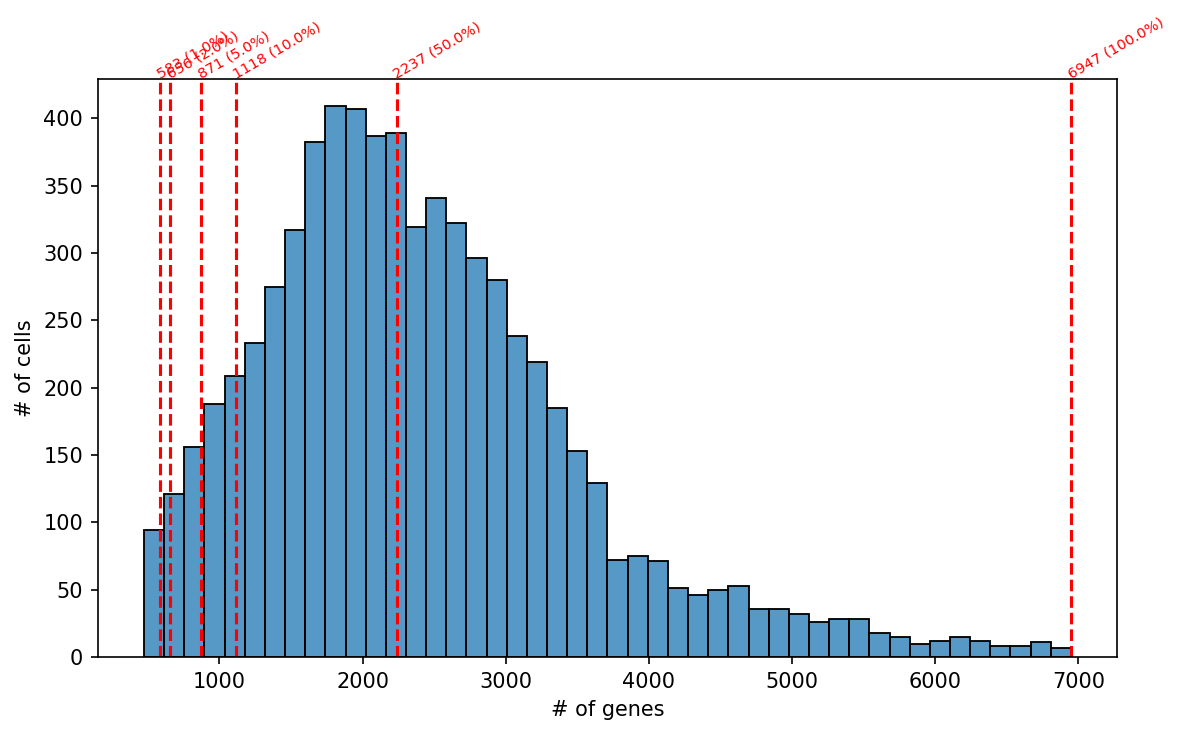

Executing PySCENIC aucell command: pyscenic aucell filtered_scenic.loom reg.csv --output pyscenic_output.loom --num_workers 12 --seed 777 --auc_threshold 0.05
Error executing PySCENIC aucell:
stdout: Create regulons from a dataframe of enriched features.
Additional columns saved: []

stderr: C:\Users\migcas\AppData\Local\anaconda3\envs\py_sc_analysis_env\lib\site-packages\loompy\bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
C:\Users\migcas\AppData\Local\anaconda3\envs\py_sc_analysis_env\lib\site-packages\loompy\bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'n

CalledProcessError: Command '['pyscenic', 'aucell', 'filtered_scenic.loom', 'reg.csv', '--output', 'pyscenic_output.loom', '--num_workers', '12', '--seed', '777', '--auc_threshold', '0.05']' returned non-zero exit status 1.

In [7]:

# ---------------------------
# Load configuration from YAML file
# ---------------------------


# Motif database
motif_file = base_project_dir / config["motif_file"]
if not motif_file.exists():
    raise FileNotFoundError(f"Motif file not found: {motif_file}")
else:
    print("Motif file found:", motif_file)

# Find feather files in base_project_dir (using pathlib)
matching_files = list(base_project_dir.glob("*.feather"))
if not matching_files:
    print(f"Warning: No .feather files found in {base_project_dir}")
else:
    print("Found .feather files:", matching_files)

# ---------------------------
# Helper function: convert DataFrame to a named numpy matrix
# ---------------------------
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    return np.array(arr_ip, dtype=dtyp)

# Compile regex pattern for progress messages (extracts number before slash)
pattern = re.compile(r"(\d+)/\d+")

# ---------------------------
# Define a processing function for each directory
# ---------------------------
def process_directory(file_prefix):
    # Build working directory using base_project_dir as root
    current_dir = base_project_dir / file_prefix
    current_dir.mkdir(parents=True, exist_ok=True)
    os.chdir(current_dir)
    print(f"Working in directory: {current_dir}")
    
    # Read the adjacency matrix from "adj.tsv"
    # Check if the adjacency matrix file "adj.tsv" exists in the current directory
    adj_file = Path("adj.tsv")
    if not adj_file.exists():
        raise FileNotFoundError("Adjacency matrix file 'adj.tsv' not found in the current directory.")
    else:
        adjacencies = pd.read_csv(str(adj_file), sep="\t", index_col=False)
        print("Adjacency matrix shape:", adjacencies.shape)
    
    
    # Define motif database file path (assumed relative to base_project_dir)
    f_motif_path = str(motif_file)
    
    # Build PySCENIC 'ctx' command, converting matching_files and motif_file to strings
    cmd = [
        "pyscenic", "ctx", "adj.tsv"
    ] + [str(f) for f in matching_files] + [
        "--annotations_fname", str(motif_file),
        "--expression_mtx_fname", "filtered_scenic.loom",
        "--output", "reg.csv",
        "--mode", "dask_multiprocessing",
        "--num_workers", "12"
    ]
    print("Executing PySCENIC ctx command:", ' '.join(cmd))
    try:
        result = subprocess.run(cmd, check=True, capture_output=True, text=True)
        print("PySCENIC ctx output:", result.stdout)
    except subprocess.CalledProcessError as e:
        print("Error executing PySCENIC ctx:")
        print("stdout:", e.stdout)
        print("stderr:", e.stderr)
        raise e

    # Load the AnnData file
    f_anndata_path = "anndata.h5ad"
    adata = sc.read_h5ad(f_anndata_path)
    
    # Calculate genes detected per cell
    nGenesDetectedPerCell = (np.sum(adata.X > 0, axis=1).A1 
                             if hasattr(adata.X, "A1") 
                             else np.array(np.sum(adata.X > 0, axis=1)).flatten())
    nGenesDetectedPerCell_series = pd.Series(nGenesDetectedPerCell)
    
    # Calculate percentiles and plot distribution
    percentiles = nGenesDetectedPerCell_series.quantile([0.01, 0.02, 0.05, 0.10, 0.50, 1])
    print("Gene detection percentiles:\n", percentiles)
    fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
    sns.histplot(nGenesDetectedPerCell, bins='fd', kde=False)
    for i, x in enumerate(percentiles):
        ax.axvline(x=x, color='red', linestyle='dashed')
        ax.text(x, ax.get_ylim()[1], f"{int(x)} ({percentiles.index.values[i]*100}%)", 
                color='red', rotation=30, size='x-small', rotation_mode='anchor')
    ax.set_xlabel('# of genes')
    ax.set_ylabel('# of cells')
    fig.tight_layout()
    plt.show()
    
    # Paths for PySCENIC 'aucell' step
    f_loom_path_scenic = "filtered_scenic.loom"
    f_pyscenic_output = "pyscenic_output.loom"
    
    # Build PySCENIC aucell command
    cmd_aucell = [
        "pyscenic", "aucell",
        f_loom_path_scenic,
        "reg.csv",
        "--output", f_pyscenic_output,
        "--num_workers", "12",
        "--seed", "777",
        "--auc_threshold", "0.05"
    ]
    print("Executing PySCENIC aucell command:", ' '.join(cmd_aucell))
    try:
        result_aucell = subprocess.run(cmd_aucell, check=True, capture_output=True, text=True)
        print("PySCENIC aucell output:", result_aucell.stdout)
    except subprocess.CalledProcessError as e:
        print("Error executing PySCENIC aucell:")
        print("stdout:", e.stdout)
        print("stderr:", e.stderr)
        raise e
    
    # Process SCENIC AUCell output
    with lp.connect(f_pyscenic_output, mode='r+', validate=False) as lf:
        auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
    print("AUCell matrix shape:", auc_mtx.shape)
    
    # Load metadata from file (assumed absolute path here; adjust if needed)
    # --- FILTER METADATA AND GENES ---
    # Read metadata from CSV and set index to 'Cell'
    df_metadata = pd.read_csv(str(metadata_path), sep=",").set_index("Cell")
    
    # Restrict metadata to cells present in the AUCell matrix
    filtered_metadata = df_metadata[df_metadata.index.isin(auc_mtx.index)]
    print("Filtered metadata shape:", filtered_metadata.shape)
    
    if auc_mtx.index.equals(filtered_metadata.index):
        print("The cell order is identical in both datasets.")
    else:
        print("Cell order differs; reordering metadata to match AUCell matrix.")
        filtered_metadata = filtered_metadata.loc[auc_mtx.index]
    
    # Compute regulon specificity scores using the metadata column 'Phase'
    # (Assuming 'Phase' is available; adjust if necessary)
    rss_cellType = regulon_specificity_scores(auc_mtx, filtered_metadata['Phase'])
    rss_cellType.to_csv("RSS.csv", index=True)
    print("Regulon specificity scores saved as 'RSS.csv'.")
    
    # Binarize AUCell output
    binary_mtx, auc_thresholds = binarize(auc_mtx, num_workers=12)
    binary_mtx.to_csv("binary_matrix.csv", index=True)
    print("Binary matrix saved as 'binary_matrix.csv'.")
    
    auc_thresholds_df = auc_thresholds.to_frame(name="auc_threshold")
    auc_thresholds_df.index.name = "Regulon"
    auc_thresholds_df.to_csv("auc_thresholds.csv")
    
    # Open the pyscenic output loom to get additional attributes
    lf = lp.connect(f_pyscenic_output, mode='r+', validate=False)
    meta = json.loads(zlib.decompress(base64.b64decode(lf.attrs.MetaData)))
    auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
    regulons = lf.ra.Regulons
    
    # Replace parentheses in column and regulon names for consistency
    auc_mtx.columns = auc_mtx.columns.str.replace(r'\(', '_(', regex=True)
    regulons.dtype.names = tuple([x.replace("(", "_(") for x in regulons.dtype.names])
    
    # Update regulon thresholds in metadata
    rt = meta['regulonThresholds']
    for i, x in enumerate(rt):
        tmp = x.get('regulon').replace("(", "_(")
        x.update({'regulon': tmp})
    
    # Create metadata JSON for the loom file
    metaJson = {
        "metrics": [
            {"name": "nUMI"},
            {"name": "nGene"},
            {"name": "Percent_mito"},
        ],
        "regulonThresholds": rt,
    }
    
    # Define final column attributes using a helper function to convert a DataFrame
    col_attrs = {
        "CellID": np.array(adata.obs.index),
        "nUMI": np.array(adata.obs['n_counts'].values),
        "nGene": np.array(adata.obs['n_genes'].values),
        "Percent_mito": np.array(adata.obs['percent_mito'].values),
        "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    }
    
    # Row attributes come from the loom file
    row_attrs = {
        "Gene": lf.ra.Gene,
        "Regulons": regulons,
    }
    
    attrs = {
        "title": "sampleTitle",
        "MetaData": base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii'),
        "Genome": "hg38",
        "SCopeTreeL1": "",
        "SCopeTreeL2": "",
        "SCopeTreeL3": "",
    }
    
    # Create the final integrated loom file
    f_final_loom = "scenic_integrated-output.loom"
    lp.create(
        filename=f_final_loom,
        layers=lf[:, :],
        row_attrs=row_attrs,
        col_attrs=col_attrs,
        file_attrs=attrs
    )
    print(f"Final integrated Loom file created: {f_final_loom}")
    lf.close()

# ---------------------------
# Process each directory using functional mapping
# ---------------------------
list(map(process_directory, file_list))
